In [10]:
##########################################################
# %%
# config
##########################################################

import os
import numpy as np
import nibabel as nib
import scipy.io as sio
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pickle
import  matplotlib.patches  as patches
from    tqdm.notebook           import tqdm
from types import SimpleNamespace

device      =   torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_slc, nx, ny, nc, ne =   6, 256, 256, 1, 6

args = SimpleNamespace()
args.num_epoch  =   5000
args.num_batch  =   6
args.num_filter =   12
args.num_replc  =   1
args.depth      =   5
args.tv_loss    =   False
args.dsize      =   (nx, ny, num_slc, ne)
args.nsize      =   (num_slc, ne, nx, ny)
args.ne         =   int(args.dsize[-1])
args.esp        =   0.608*1e-3                          # sec
args.TEs        =   2.948*1e-3 + np.arange(args.ne) * args.esp    # sec
args.device     =   device
args.nmean      =   0       # noise
args.nstd       =   0.1     # noise

model_path      = "net/NTD_v1.pth"
# activation_type = 'sigmoid' # 'LeakyReLU' #
# kernel_size =   (2,2)

# Define the file path to save the losses
losses_path     = "net/NTD_v1.pkl"
res_mat         = "res/NTD_v1.mat"

In [11]:
##########################################################
# %%
# Define the custom Dataset class
##########################################################
class LiverDataset(Dataset):
    def __init__(self, data1, data2, args, istrain = True):
        self.data1      =   data1
        self.data2      =   data2
        self.args       =   args
        self.istrain    =   istrain

    def __len__(self):
        return len(self.data1)
    
    def add_complex_gaussian_noise(self, image):
        # Generate real and imaginary Gaussian noise
        # (mag, phs)
        real_noise = np.random.normal(self.args.nmean, self.args.nstd, args.nsize)
        imag_noise = np.random.normal(self.args.nmean, self.args.nstd, args.nsize)
         
        # Create complex noise
        complex_noise   =   real_noise + 1j * imag_noise            
        complex_signal  =   image[:,:self.args.ne,] * np.exp(1j * image[:,self.args.ne:,])

        noisy_image = complex_noise + complex_signal
        noisy_out   = np.concatenate((np.abs(noisy_image), np.angle(noisy_image)), axis=1)

        return noisy_out

    def __getitem__(self, idx):
        if self.istrain:
            return (torch.tensor(self.data1[idx,:self.args.ne,], dtype=torch.float32).to(args.device),      #   magnitude
                    torch.tensor(self.data1[idx,self.args.ne:,], dtype=torch.float32).to(args.device),      #   phase
                    torch.tensor(self.data2[idx], dtype=torch.float32).to(args.device))                     #   mag + phs, reference
            # noisy_image = self.add_complex_gaussian_noise(np.copy(self.data1))
            # # noisy_image.shape:  6, 24, 256, 256
            # return (torch.tensor(noisy_image[idx,:self.args.ne,], dtype=torch.float32).to(args.device),      #   magnitude
            #         torch.tensor(noisy_image[idx,self.args.ne:,], dtype=torch.float32).to(args.device),      #   phase
            #         torch.tensor(self.data2[idx], dtype=torch.float32).to(args.device))                     #   mag + phs, reference
        else:
            return (torch.tensor(self.data1[idx,:self.args.ne,], dtype=torch.float32).to(args.device),      #   magnitude
                    torch.tensor(self.data1[idx,self.args.ne:,], dtype=torch.float32).to(args.device),      #   phase
                    torch.tensor(self.data2[idx], dtype=torch.float32).to(args.device))                     #   mag + phs, reference

In [12]:
def mosaic(img, num_row, num_col, fig_num, clim, title='', use_transpose=False, use_flipud=False):
    fig = plt.figure(fig_num)
    fig.patch.set_facecolor('black')

    if img.ndim < 3:
        img_res = img
        plt.imshow(img_res)
        plt.gray()
        plt.clim(clim)
    else:
        if img.shape[2] != (num_row * num_col):
            print('sizes do not match')
        else:
            if use_transpose:
                for slc in range(0, img.shape[2]):
                    img[:, :, slc] = np.transpose(img[:, :, slc])
            if use_flipud:
                img = np.flipud(img)
            img_res = np.zeros((img.shape[0] * num_row, img.shape[1] * num_col))
            idx = 0
            for r in range(0, num_row):
                for c in range(0, num_col):
                    img_res[r * img.shape[0]: (r + 1) * img.shape[0], c * img.shape[1]: (c + 1) * img.shape[1]] = img[:,
                                                                                                                  :,
                                                                                                                  idx]
                    idx = idx + 1
        plt.imshow(img_res)
        plt.gray()
        plt.clim(clim)

    plt.suptitle(title, color='white', fontsize=48)

In [13]:
##########################################################
# %%
# Define the U-Net Model
##########################################################
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, args):
        super(UNet, self).__init__()

        self.depth = args.depth

        # First U-Net (Unet1)
        self.cnn1_1 = self.conv_block(in_channels, args.num_filter)
        self.encoder1 = nn.ModuleList()
        self.decoder1 = nn.ModuleList()

        for i in range(args.depth):
            self.encoder1.append(
                self.conv_block(
                    args.num_filter * (2 ** i),
                    args.num_filter * (2 ** (i + 1))
                )
            )

        self.middle_conv1 = self.conv_block(args.num_filter * (2 ** args.depth), args.num_filter * (2 ** (args.depth + 1)))

        for i in range(args.depth):
            self.decoder1.append(
                self.conv_block(
                    args.num_filter * (2 ** (args.depth - i + 1)) + args.num_filter * (2 ** (args.depth - i)),
                    args.num_filter * (2 ** (args.depth - i))
                )
            )

        self.final_conv1 = nn.Conv2d(args.num_filter * 2, out_channels, kernel_size=1)

        # Second U-Net (Unet2)
        self.cnn1_2 = self.conv_block(in_channels, args.num_filter)
        self.encoder2 = nn.ModuleList()
        self.decoder2 = nn.ModuleList()

        for i in range(args.depth):
            self.encoder2.append(
                self.conv_block(
                    args.num_filter * (2 ** i),
                    args.num_filter * (2 ** (i + 1))
                )
            )

        self.middle_conv2 = self.conv_block(args.num_filter * (2 ** args.depth), args.num_filter * (2 ** (args.depth + 1)))

        for i in range(args.depth):
            self.decoder2.append(
                self.conv_block(
                    args.num_filter * (2 ** (args.depth - i + 1)) + args.num_filter * (2 ** (args.depth - i)),
                    args.num_filter * (2 ** (args.depth - i))
                )
            )

        self.final_conv2 = nn.Conv2d(args.num_filter * 2, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(2,2), padding='same'),
            nn.BatchNorm2d(out_channels),
            # nn.LeakyReLU(inplace=True),
            nn.Sigmoid(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(2,2), padding='same'),
            nn.BatchNorm2d(out_channels),
            # nn.LeakyReLU(inplace=True),
            nn.Sigmoid()
        )
    
    def Unet1(self, x):
        skips = []
        
        x = self.cnn1_1(x)

        # Encoder
        for encoder in self.encoder1:
            x = encoder(x)
            skips.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Bottleneck
        x = self.middle_conv1(x)

        # Decoder
        for i, decoder in enumerate(self.decoder1):
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
            x = torch.cat((x, skips[-(i + 1)]), dim=1)
            x = decoder(x)

        x = self.final_conv1(x)
        return x
    
    def Unet2(self, x):
        skips = []
        
        x = self.cnn1_2(x)

        # Encoder
        for encoder in self.encoder2:
            x = encoder(x)
            skips.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Bottleneck
        x = self.middle_conv2(x)

        # Decoder
        for i, decoder in enumerate(self.decoder2):
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
            x = torch.cat((x, skips[-(i + 1)]), dim=1)
            x = decoder(x)

        x = self.final_conv2(x)
        return x

    def forward(self, x1, x2):
        o1 = self.Unet1(x1)
        o2 = self.Unet2(x2)
        
        return torch.cat((o1, o2), dim=1)



In [14]:
##########################################################
# %%
# Define the custom loss function
##########################################################
class CustomLoss(nn.Module):
    def __init__(self, args):
        super(CustomLoss, self).__init__()
        self.args       =   args
        self.FatPhs     =   torch.tensor(np.reshape(args.FatPhs,(1,ne,1,1)), dtype=torch.complex64).to(args.device)
        self.TEs        =   torch.tensor(np.reshape(args.TEs,(1,ne,1,1)), dtype=torch.float32).to(args.device)
        self.ne         =   args.ne

    def forward(self, y_true, y_pred):
        input_train_tm_tens = y_true[:,:self.ne,]
        input_train_tp_tens = y_true[:,self.ne:2 * self.ne,]

        wat_r   = y_pred[:, 0:1, :, :].repeat(1, self.ne, 1, 1)
        wat_r   = wat_r * self.args.w_std_r + self.args.w_mean_r

        fat_r   = y_pred[:, 1:2, :, :].repeat(1, self.ne, 1, 1)
        fat_r   = fat_r * self.args.f_std_r + self.args.f_mean_r

        wat_i   = y_pred[:, 3:4, :, :].repeat(1, self.ne, 1, 1)
        wat_i   = wat_i * self.args.w_std_i + self.args.w_mean_i

        fat_i   = y_pred[:, 4:5, :, :].repeat(1, self.ne, 1, 1)
        fat_i   = fat_i * self.args.f_std_i + self.args.f_mean_i

        frq     = y_pred[:, 5:6, :, :].repeat(1, self.ne, 1, 1)
        frq     = frq * self.args.frq_std + self.args.frq_mean

        r2      = y_pred[:, 2:3, :, :].repeat(1, self.ne, 1, 1)
        r2      = r2 * self.args.r2_std + self.args.r2_mean

        pi_cmp = torch.tensor(np.pi, dtype=torch.float32, device=y_pred.device)

        signal = (  wat_r * torch.exp(-1j * wat_i) + \
                    fat_r * torch.exp(-1j * fat_i) *  self.FatPhs) * \
                        torch.exp(-r2 * self.TEs ) * torch.exp(-1j * 2 * pi_cmp * frq * self.TEs)

        input_train_t_mag = input_train_tm_tens[:, :self.ne, :, :]
        input_train_t_phs = input_train_tp_tens[:, :self.ne, :, :]

        gt_input_train2 = torch.abs(input_train_t_mag) * torch.exp(1j * input_train_t_phs)

        loss = torch.sqrt(torch.norm(torch.abs(gt_input_train2 - signal), dim=-1).sum())

        if self.args.tv_loss:
            tv_loss = torch.mean(torch.norm(frq, p=2, dim=(2, 3))) / frq.shape[2] / frq.shape[3] / 3.0 / (100.0 / self.ne)
            loss    = loss + tv_loss
            # loss += torch.mean(torch.norm(frq, p=2, dim=(2, 3))) / frq.shape[2] / frq.shape[3] / 3.0 / (100.0 * 12.0 / self.ne)

        return loss

In [15]:
##########################################################
# %%
# Load Data
##########################################################
def load_h5py(filename, rmod='r'):
    with h5py.File(filename, rmod) as f:
        arr = {}
        for k, v in f.items():
            arr[k] = np.transpose(np.array(v))
        return arr

path_mat    =   '/mnt/hdd1/users/jcho/IDEAL-net/mat/'
str_dat     =   sio.loadmat(path_mat + 'Axial_Liver_3T_multicoil_12echo.mat')
img_ref     =   np.squeeze(str_dat['imDataParams']['images'].item())

img_ref     =   img_ref[:, :, :, :args.ne] / 1e3

# Reshape and Prepare Data
img_trn1    =   np.expand_dims(img_ref, axis=0)
img_trn2    =   np.expand_dims(img_ref, axis=0)

img_trn1_reshape = np.reshape(np.transpose(img_trn1, (0, 3, 1, 2, 4)), (num_slc, nx, ny, args.ne))
img_trn2_reshape = np.reshape(np.transpose(img_trn2, (0, 3, 1, 2, 4)), (num_slc, nx, ny, args.ne))

input_train_t1  = np.concatenate((np.abs(img_trn1_reshape), np.angle(img_trn1_reshape)), axis=-1)
input_train_t2  = np.concatenate((np.abs(img_trn2_reshape), np.angle(img_trn2_reshape)), axis=-1)

input_train_t1  = np.repeat(input_train_t1, args.num_replc, axis=0)
input_train_t2  = np.repeat(input_train_t2, args.num_replc, axis=0)

input_train_t1  = np.transpose(input_train_t1,(0,3,1,2))
input_train_t2  = np.transpose(input_train_t2,(0,3,1,2))

# DataLoader
dataset         = LiverDataset(input_train_t1, input_train_t2, args, istrain = True)
dataloader      = DataLoader(dataset, batch_size=args.num_batch, shuffle=True)

In [16]:
##########################################################
# %%
# Initialize Model, Loss, and Optimizer
##########################################################

model = UNet(in_channels=ne, out_channels=3, args=args)

try:
    model.load_state_dict(torch.load(model_path))
    print('successful to load the model')
except:
    print('failed to load the model')

model = model.to(args.device)

/tmp/ipykernel_1186782/4169234703.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


successful to load the model


In [17]:
##########################################################
# %%
# Multipeak Fat Model
##########################################################
FatFrq = np.array( (-467.6136, -418.3911, -319.9461, -238.7290,  -47.9919,   73.8337))
RelAmp = np.array( (0.087, 0.693, 0.128, 0.004, 0.039, 0.048))
# counter clock-wise
FatPhs = np.exp(-1j*2*np.pi*np.reshape(FatFrq,(len(FatFrq),1))*np.reshape(args.TEs,(1,len(args.TEs))))
FatPhs = np.reshape(np.sum(FatPhs*np.reshape(RelAmp,(len(RelAmp),1)),axis=0),(1,1,1,ne))
print(FatPhs)

args.FatPhs     =   FatPhs
#======z-score calculated from average of multiple datasets=========
args.w_mean_r   = float(0.3)
args.w_std_r    = float(0.1)
args.f_mean_r   = float(0.3)
args.f_std_r    = float(0.1)
args.frq_mean   = float(30)
args.frq_std    = float(30)
args.r2_mean    = float(80)
args.r2_std     = float(50)
args.w_mean_i   = float(0)
args.w_std_i    = float(1)
args.f_mean_i   = float(0)
args.f_std_i    = float(1)

[[[[ 0.16226496+0.68410048j -0.6360826 +0.0594022j
    -0.01590031-0.61722447j  0.55567395+0.05332025j
    -0.15483331+0.57242936j -0.61272382-0.14792407j]]]]


Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

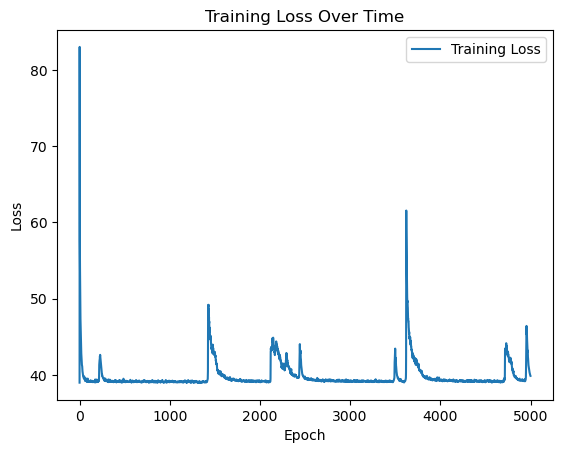

In [18]:
##########################################################
# %%
# 
##########################################################

loss_fn = CustomLoss(args=args)
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-09, weight_decay=0.001)

##########################################################
# %%
# Training Loop
##########################################################

# Initialize a list to store the losses
train_losses    = []
loss_min        = 1e10
loss_min_ind    = 0

# Training loop
model.train()

with tqdm(range(args.num_epoch), desc='Epoch') as pbar:
    for epoch in pbar:
        running_loss = 0.0
        for i, (input1, input2, labels) in enumerate(dataloader):

            optimizer.zero_grad()
            outputs = model(input1, input2)
            loss    = loss_fn(labels, outputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate the average loss for this epoch
        avg_loss = running_loss / len(dataloader)
        train_losses.append(avg_loss)

        # if epoch % 50 == 0:
        #     print(f'Epoch [{epoch+1}/{args.num_epoch}], Loss: {avg_loss:.4f}')

        if loss_min >= avg_loss:
            loss_min = avg_loss
            loss_min_ind = epoch
            # Save the Model
            torch.save(model.state_dict(), model_path)
            # print(f'Save! Epoch [{epoch+1}/{args.num_epoch}], Loss: {avg_loss:.4f}')

        # tqdm bar 업데이트
        pbar.set_postfix({  'Epoch': f'{epoch+1:7d}',      # 정수 포맷으로 표시
                            'Loss': f'{avg_loss:3.2f}',
                            'Best Epoch': f'{loss_min_ind+1:7d}', 
                            'Best Loss': f'{loss_min:3.2f}'   })

       
# Plot the training losses
plt.figure()
plt.plot(np.arange(len(train_losses)), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

# Save the losses
with open(losses_path, 'wb') as f:
    pickle.dump(train_losses, f)

/tmp/ipykernel_1186782/2070345970.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


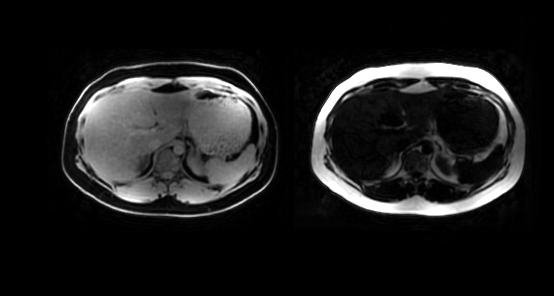

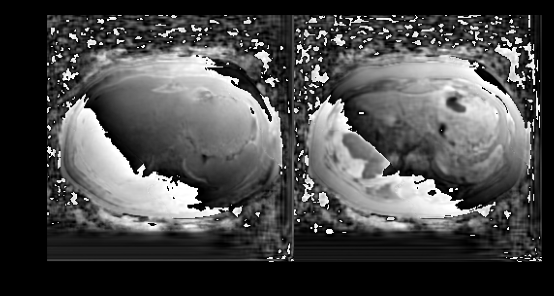

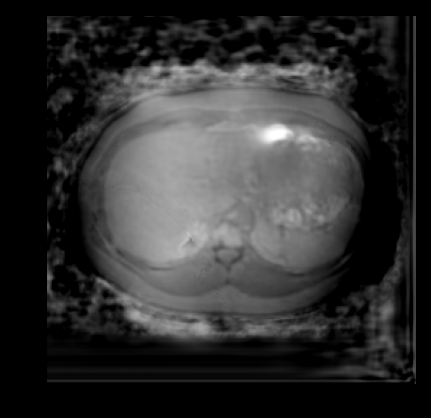

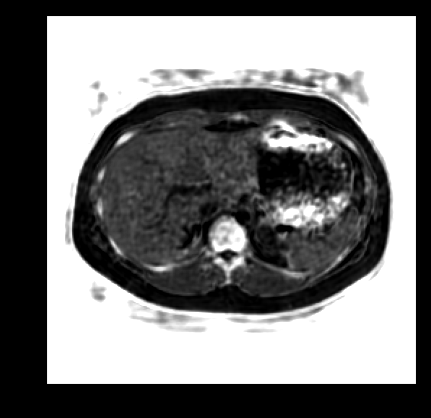

In [19]:
##########################################################
# %%
# Test Network
##########################################################

model.load_state_dict(torch.load(model_path))

# Evaluate on Test Data
model.eval()


with torch.no_grad():
    test_input1 = torch.tensor(np.abs(img_ref), dtype=torch.float32).permute(2, 3, 0, 1).to(args.device)
    test_input2 = torch.tensor(np.angle(img_ref), dtype=torch.float32).permute(2, 3, 0, 1).to(args.device)
    test_output = model(test_input1,test_input2)
    # eloss = loss_fn(torch.tensor(test_output, dtype=torch.float32).permute(0, 3, 1, 2), test_output)

test_output = test_output.cpu().numpy()

#==========display results==========
slc_select = 2
wat_mag = np.abs(np.squeeze(test_output[:,0,] * args.w_std_r + args.w_mean_r))
fat_mag = np.abs(np.squeeze(test_output[:,1,] * args.f_std_r + args.f_mean_r))
wat_phs = np.exp(-1j * test_output[:,3,] * args.w_std_i + args.w_mean_i)
fat_phs = np.exp(-1j * test_output[:,4,] * args.f_std_i + args.f_mean_i)
frq     = np.squeeze(test_output[:,5,] * args.frq_std + args.frq_mean)
r2      = np.squeeze(test_output[:,2,] * args.r2_std + args.r2_mean)
mosaic(np.stack((np.abs(wat_mag[slc_select,]), np.abs(fat_mag[slc_select,])), axis=-1), 1, 2, 201, (0,0.8))
mosaic(np.stack((np.angle(wat_phs[slc_select,]), np.angle(fat_phs[slc_select,])), axis=-1), 1, 2, 204, (-3,3))
mosaic((frq[slc_select,]), 1, 1, 202, (-100,100))
mosaic((r2[slc_select,]), 1, 1, 203, (0,200))

sio.savemat(res_mat,{'wat_mag':wat_mag,'fat_mag':fat_mag,'wat_phs':wat_phs,'fat_phs':fat_phs,'frq':frq,'r2':r2})



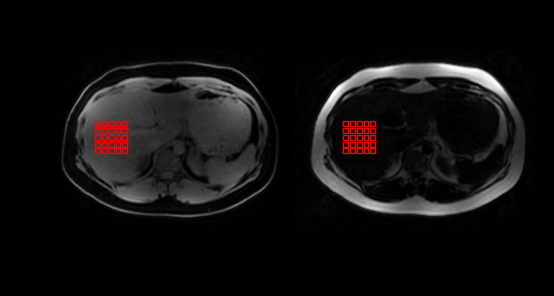

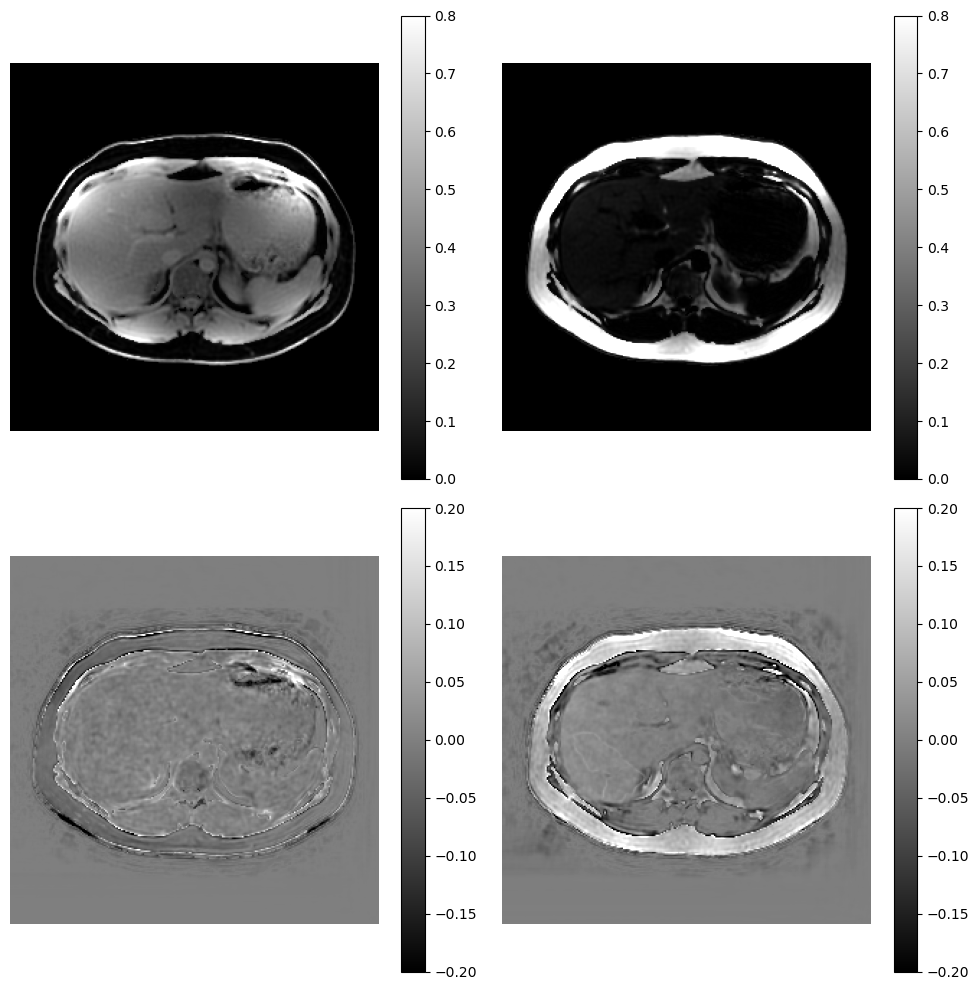

wat_mag_cmp shape: (256, 256)


"\nwat_mag_cmp = np.abs(img_cmp['outParams']['species'][0][0]['amps'][0][0]) / 1e3\nmosaic(np.abs(wat_mag_cmp), 1, 2, 211, (0,0.8))\nfat_mag_cmp = np.abs(img_cmp['outParams']['species'][0][0]['amps'][0][1]) / 1e3\nmosaic(np.abs(fat_mag_cmp), 1, 2, 212, (0,0.8))\n\nmosaic(np.abs(wat_mag_cmp) - wat_mag, 1, 2, 213, (-0.2,0.2))\nmosaic(np.abs(fat_mag_cmp) - fat_mag, 1, 2, 214, (-0.2,0.2))"

In [20]:
##########################################################
# %%
# Comparison
##########################################################

fig1, ax1 = plt.subplots(1)
ax1.imshow(np.concatenate((np.abs(wat_mag[slc_select,]), np.abs(fat_mag[slc_select,])), axis=1))
fig1.patch.set_facecolor('black')

box_plot = (50, 110, 5, 5)  # (x, y, width, height)

for ii in np.arange(5):
  for jj in np.arange(5):
    rect1 = patches.Rectangle((box_plot[0]+ii*7, box_plot[1]+jj*7), box_plot[2], box_plot[3], linewidth=1, edgecolor='r', facecolor='none')
    rect2 = patches.Rectangle((box_plot[0]+nx+ii*7, box_plot[1]+jj*7), box_plot[2], box_plot[3], linewidth=1, edgecolor='r', facecolor='none')
    ax1.add_patch(rect1)
    ax1.add_patch(rect2)
plt.show()

'''
fig1, ax1 = plt.subplots(5, 5, figsize=(10, 10))  # Adjust figsize as needed
for ii in np.arange(5):
    for jj in np.arange(5):
        im = ax1[jj, ii].imshow(np.abs(wat_mag[slc_select, (box_plot[1] + jj * 7):(box_plot[1] + box_plot[3] + jj * 7),
                                                (box_plot[0] + ii * 7):(box_plot[0] + box_plot[2] + ii * 7)]),
                                cmap='gray', vmin=0, vmax=0.8)
        ax1[jj, ii].axis('off')  # Optional: turn off axis labels for clarity

plt.tight_layout()  # Optional: adjust subplots to fit into the figure area
plt.show()
'''

# ax1[0,1].imshow(np.abs(fat_mag[box_plot[1]:box_plot[1]+box_plot[3],box_plot[0]:box_plot[0]+box_plot[2]]))
# ax1.imshow(np.concatenate((np.abs(wat_mag), np.abs(fat_mag)), axis=1))
# fig1.patch.set_facecolor('black')

# img_cmp = sio.loadmat( path_mat + 'outParams_Axial_Liver_3T_multicoil_12echo.mat')
img_cmp = sio.loadmat( 'mat/outParamsRef_Axial_Liver_3T_12echo.mat')

# Compute the magnitudes
wat_mag_cmp = np.abs(img_cmp['outParamsRef']['species'][0][0]['amps'][0][0]) / 1e3
fat_mag_cmp = np.abs(img_cmp['outParamsRef']['species'][0][0]['amps'][0][1]) / 1e3

# Create the subplots and include color bars
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

im1 = axs[0, 0].imshow(np.abs(wat_mag_cmp), cmap='gray', vmin=0, vmax=0.8)
axs[0, 0].axis('off')
fig.colorbar(im1, ax=axs[0, 0])

im2 = axs[0, 1].imshow(np.abs(fat_mag_cmp), cmap='gray', vmin=0, vmax=0.8)
axs[0, 1].axis('off')
fig.colorbar(im2, ax=axs[0, 1])

im3 = axs[1, 0].imshow(np.abs(wat_mag_cmp) - wat_mag[slc_select,], cmap='gray', vmin=-0.2, vmax=0.2)
axs[1, 0].axis('off')
fig.colorbar(im3, ax=axs[1, 0])

im4 = axs[1, 1].imshow(np.abs(fat_mag_cmp) - fat_mag[slc_select,], cmap='gray', vmin=-0.2, vmax=0.2)
axs[1, 1].axis('off')
fig.colorbar(im4, ax=axs[1, 1])

plt.tight_layout()
plt.show()

print('wat_mag_cmp shape: ' + str(wat_mag_cmp.shape))


'''
wat_mag_cmp = np.abs(img_cmp['outParams']['species'][0][0]['amps'][0][0]) / 1e3
mosaic(np.abs(wat_mag_cmp), 1, 2, 211, (0,0.8))
fat_mag_cmp = np.abs(img_cmp['outParams']['species'][0][0]['amps'][0][1]) / 1e3
mosaic(np.abs(fat_mag_cmp), 1, 2, 212, (0,0.8))

mosaic(np.abs(wat_mag_cmp) - wat_mag, 1, 2, 213, (-0.2,0.2))
mosaic(np.abs(fat_mag_cmp) - fat_mag, 1, 2, 214, (-0.2,0.2))'''


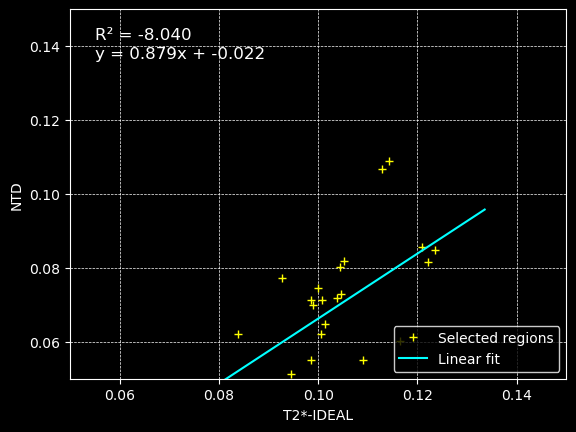

In [21]:

wat_pro = np.empty((5,5))
wat_cmp = np.empty((5,5))
fat_pro = np.empty((5,5))
fat_cmp = np.empty((5,5))

for ii in np.arange(5):
  for jj in np.arange(5):
    wat_pro[ii,jj] = np.mean(wat_mag[slc_select,(box_plot[1]+jj*7):(box_plot[1]+box_plot[3]+jj*7),(box_plot[0]+ii*7):(box_plot[0]+box_plot[2]+ii*7)])
    wat_cmp[ii,jj] = np.mean(wat_mag_cmp[(box_plot[1]+jj*7):(box_plot[1]+box_plot[3]+jj*7),(box_plot[0]+ii*7):(box_plot[0]+box_plot[2]+ii*7)])
    fat_pro[ii,jj] = np.mean(fat_mag[slc_select,(box_plot[1]+jj*7):(box_plot[1]+box_plot[3]+jj*7),(box_plot[0]+ii*7):(box_plot[0]+box_plot[2]+ii*7)])
    fat_cmp[ii,jj] = np.mean(fat_mag_cmp[(box_plot[1]+jj*7):(box_plot[1]+box_plot[3]+jj*7),(box_plot[0]+ii*7):(box_plot[0]+box_plot[2]+ii*7)])

# Calculate PDFF
pdff_cmp = np.reshape(fat_cmp / (wat_cmp + fat_cmp), (25,))
pdff_pro = np.reshape(fat_pro / (wat_pro + fat_pro), (25,))

# Set up the figure with a black background
plt.figure(facecolor='black')

# Plot the data points with a bright color
plt.plot(pdff_cmp, pdff_pro, '+', label='Selected regions', color='yellow')  # Bright yellow points

# Perform a linear fit
coefficients = np.polyfit(pdff_cmp, pdff_pro, 1)  # Fit a 1st degree polynomial (linear)
x_fit = np.linspace(pdff_cmp.min() - 0.01, pdff_cmp.max() + 0.01, 100)  # Extend the range slightly
linear_fit = np.polyval(coefficients, x_fit)  # Get the fitted line values over the extended range

# Plot the linear fit with a bright color
plt.plot(x_fit, linear_fit, '-', label='Linear fit', color='cyan')  # Bright cyan line

# Set the limits for x and y axes
plt.xlim(0.05, 0.15)  # Adjust these values based on the expected range of pdff_cmp
plt.ylim(0.05, 0.15)  # Adjust these values based on the expected range of pdff_pro

# Add plot details with white text
# plt.title('PDFF', color='white')
plt.ylabel('NTD', color='white')
plt.xlabel('T2*-IDEAL', color='white')
plt.legend(loc='lower right', facecolor='black', edgecolor='white', labelcolor='white')

# Calculate and display R² value on the plot with white text
r2 = r2_score(pdff_cmp, pdff_pro)
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, color='white', verticalalignment='top')

# Display the fitted line equation on the plot
slope, intercept = coefficients
equation_text = f'y = {slope:.3f}x + {intercept:.3f}'
plt.text(0.05, 0.90, equation_text, transform=plt.gca().transAxes, fontsize=12, color='white', verticalalignment='top')

# Set plot background to black and customize axis appearance
ax = plt.gca()
ax.set_facecolor('black')

# Change the color of the axes lines to white
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

# Change the color of the tick marks (major and minor) to white
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Add a white grid
ax.grid(True, color='white', linestyle='--', linewidth=0.5)


plt.savefig('fig/fit_ex1.png', dpi=300, bbox_inches='tight')

In [22]:
import gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()